# Introduction & Motivation

Topic models take a corpus of human-readable text documents and cluster them.  The idea is that documents are assigned to the same cluster when they are "about" the same topic.  The field has advanced a long way since the introduction of _Latent Dirichlet Allocation_ back in 2003.  These days deep learning topic models are in vogue.  In particular, BERT-based topic models are appealing because they can naturally handle out-of-vocabulary tokens and generate powerful text embeddings.

This notebook is a stripped-down version of something I created for finding granular topics in short-form social media texts.  I had been experimenting with many published models - including Bayesian ones, non-negative matrix factrisation methods and deep-learning based ones but was not getting the results I wanted.  My particular use case required low-level, granular topics - essentially I wanted to define a topic as a particular variation of a claim, an event or a specifc belief.  Everything I tried was either returning broader topics ("COVID 19", "war in ukraine", etc) - or it was totally failing to get to grips with the truncated nature of short-form posts (like tweets).

I took inspiration from Dimo Angelov's **top2vec** paper (https://arxiv.org/abs/2008.09470).  The author bolted together an embedding layer - which generated 768-dimensional, dense vectors - with UMAP to reduce said dimensionality and finally HDBScan to yield a partial clustering of the documents.  The centroid of the found clusters could then be reprojected into the embedding space, yielding a joint embedding of documents and topics.

Lovely though the process is I couldn't achieve good results on my short-form data at the level of granularity I wanted.  So I have adapted Dimo's approach, and it works really nicely.  What follows is a first step towards a model that clusters tweets at the level of a particular claim, statistic or event.  (This is not about identifying or evaluating claims and opinions _per se_.)

The process is as follows:

1. Properly prepare the tweets, removing URLS and hashtags (which tend to be unhelpful when they appear in groups).
2. Fine-tune a BERT model using SimCSE - a form of Multiple Negative-Ranking Loss.  This yields an embedding tuned to the specific domains of the data I am working with.
3. Use the fine-tuned model to embed the tweets.
4. Build an (approximate) neareset-neighbours index over the embedded tweets.  This enables us to efficiently find similar tweets without having to make $\mathcal{O}\left(N^2\right)$ comparisons.
5. Build a graph where each tweet is a node and each nearest neighbour (above a similarity threshold) is an edge.
6. Run a simple community detection algorithm over the graph.

Voila: topics.

### A Word on Data

This notebook uses a set of tweets, collected in 2022 with keywords that relate to the cost of living crisis and the then Prime Minister's alleged breaches of the UK's COVID-19 lockdown rules.  Twitter's terms of use do not allow for their data to be shared, but this notebook will work on any set of tweets you may have to hand (I've tested it against lots of them!)

In [1]:
import seaborn as sns
import pandas as pd
import re
from textacy import preprocessing
from functools import partial
from sentence_transformers import SentenceTransformer, InputExample, models, losses
from torch.utils.data import DataLoader
from gensim.models.keyedvectors import KeyedVectors
from gensim.similarities.annoy import AnnoyIndexer
import numpy as np
from tqdm import tqdm
import networkx as nx
from networkx import NetworkXError
from cdlib.algorithms import label_propagation
from collections import namedtuple, Counter
from matplotlib import pyplot as plt
from termcolor import colored

C:\Users\Will\Anaconda3\envs\deepseer3\lib\site-packages\huggingface_hub\snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'karateclub', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg'}


In [2]:
sns.set(rc={'figure.figsize':(20,10)})
pd.set_option('display.max_colwidth', 150)

In [3]:
RANDOM_SEED = 42                 # For repeatable experiments
REBUILD = True                   # Set to TRUE to force a rebuild of the core transformer, embeddings, Annoy index and sim-graph

# Data extraction
PROJECT_SAMPLE_SIZE = 100000     # The number of source tweets we'll retrieve

# Pre-processing 
MAX_HASHTAGS_BEFORE_REMOVAL = 0  # If there are more than this many hashtags in a tweet, remove them all.

# Dictionary-building
MIN_TOKEN_COUNT = 20             # Minimum # token occurances for a dictionary entry
MAX_TOKEN_FREQ = 0.25            # When building the token dictionary, any token appearing in more than this % of documents is pruned

# Fine-tuning
N_TRAINING_EPOCHS = 2            # Number of epochs of fine-tuning for the transformer.
MAX_SEQ_LEN = 100                # Large enough for the vast majority of tweets.

# Indexing
NUM_ANNOY_TREES = 1              # How many NN trees to build.  More trees = more accurate recall.

# Topic Graph
MIN_SIM_SCORE = 0.45             # Minimum similarity between embedding vectors to yield an edge in the topic graph.
MIN_CLUSTER_SIZE = 20            # Discard topic clusters with fewer than this number of members.

# Data Preprocessing

Minimally clean the data, making it suitable for BERT finetuning.

In [4]:
df = pd.read_csv(f"./data/data.csv").dropna()
print(f"Dataset contains [{df.shape[0]}] rows.")

Dataset contains [100000] rows.


### Strip URLs

First find all of the t.co URLs and place them into a new column.  Remove them from the tweet text.

In [5]:
URLS_RE = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")

df['urls'] = df.tweet_text.apply(URLS_RE.findall)

In [6]:
# Remove the URLs from the tweet text

def remove_urls(row):
    tweet_text = row.tweet_text
    for u in row.urls:
         tweet_text = tweet_text.replace(u, '')
    return tweet_text.strip()

df.tweet_text = df.apply(remove_urls, axis='columns')

### Basic Text Preprocessing

The only point here of note is the handling of hashtags.  Tweets often contain a large number of hashtags appended to the main body of the text.  I've found these actually _detract_ from the ability of topic models to do their work properly.  So in the pre-processing code below, if there are more than `MAX_HASHTAGS_BEFORE_REMOVAL` hashtags then _all_ of them will be removed.

In [7]:
replace_user_handles = partial(preprocessing.replace.user_handles, repl='')
replace_urls = partial(preprocessing.replace.urls, repl='')
replace_hashtags = partial(preprocessing.replace.hashtags, repl='')
remove_ampersand = lambda text: text.replace('&amp', '')
remove_newline = lambda text: text.replace('\n', ' ')
replace_emojis = partial(preprocessing.replace.emojis, repl='')
delete_chars = lambda text: text.replace("'", "").replace("-", "")

preproc = preprocessing.make_pipeline(
    preprocessing.normalize.bullet_points,
    preprocessing.normalize.quotation_marks,
    preprocessing.normalize.whitespace,
    preprocessing.normalize.unicode,
    preprocessing.remove.accents,
    replace_urls,
    remove_ampersand,
    delete_chars,    
    replace_user_handles,
    preprocessing.remove.punctuation,    
    replace_emojis,
    remove_newline,
    preprocessing.remove.brackets,
    preprocessing.normalize.whitespace
)

preproc_no_hashtags = preprocessing.make_pipeline(
    preprocessing.normalize.bullet_points,
    preprocessing.normalize.quotation_marks,
    preprocessing.normalize.whitespace,
    preprocessing.normalize.unicode,
    preprocessing.remove.accents,
    replace_urls,
    remove_ampersand,    
    # Replace hashtags with the empty string before we handle punctuation
    replace_hashtags,
    replace_user_handles,
    delete_chars,
    preprocessing.remove.punctuation,
    replace_emojis,
    remove_newline,
    preprocessing.remove.brackets,
    preprocessing.normalize.whitespace
)

In [8]:
def preprocess(text, hashtag_threshold=MAX_HASHTAGS_BEFORE_REMOVAL):
    if text.count("#") > hashtag_threshold:
        return preproc_no_hashtags(text)
    else:
        return preproc(text)

In [9]:
df['preprocessed_text'] = [preprocess(t) for t in df.tweet_text.values]

In [11]:
n_docs = df.shape[0]

# Embedding

## Finetune the SimCSE transformer

The SimCSE model (https://arxiv.org/abs/2104.08821) works as follows:

1. Start with a pretrained BERT transformer model to obtain fixed-dimensional word embeddings.  We use DistilRoBERTa (https://huggingface.co/docs/transformers/model_doc/distilbert) as the base. This is based on the RoBERTa model which only trains against the Masked Language Model (MLM) objective.  Dropout is set to 0.1 as standard.
2. Stack a mean-pooling layer on top.  (The `all-distilroberta-v1` model was trained using mean-pooling, not the CLS token, to generate document embeddings.)
3. Training examples consist of pairs of the same document (dropout masks are be applied separately, and randomly, to each item in a pair).
4. Use the Multiple Negatives Ranking (MNR) Loss.  For example $x_i$ in a batch of $K$ input pairs the loss function evaluates:

\begin{align}
\mathcal{l}_i &= - \text{log } \mathbf{P}\left(x_i | x_i\right) \\
& \approx -\text{log } \left( \frac{e^{\text{sim}\left(z_i^{\left(1\right)}, z_i^{\left(2\right)}\right)}}{\sum_{k=1}^{K}e^{\text{sim}\left(z_i^{\left(1\right)}, z_k^{\left(2\right)}\right)}} \right) \\
&\approx -\text{sim}\left(z_i^{\left(1\right)}, z_i^{\left(2\right)}\right) + \text{log } \left(\sum_{k=1}^{K}e^{\text{sim}\left(z_i^{\left(1\right)}, z_k^{\left(2\right)}\right)} \right)
\end{align}
Where $\text{sim}$ is the cosine similarity function, $z_i$ is the mean-embedding vector for example $x_i$ and the superscripts $z_i^{\left(1\right)}$ and $z_i^{\left(2\right)}$ denote the dropout masks applied to the first and second elements of the input pair, respectively.  (MNR loss is therefore effectively just a form of cross-entropy loss.)

In [12]:
def finetune_simcse():

    # Cased version of DistilRoBERTa.
    model_name = 'sentence-transformers/all-distilroberta-v1'

    word_embedding_model = models.Transformer(model_name, max_seq_length=32)

    pooling_model = models.Pooling(
        word_embedding_dimension=word_embedding_model.get_word_embedding_dimension(),
        pooling_mode='mean'
    )

    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # SimCSE uses masked pairs of inputs.
    train_data = [InputExample(texts=[doc, doc]) for doc in df.preprocessed_text.to_numpy()]

    # Batch the data.  Larger batches make the MNR loss more accurate.
    # Shuffling super-important, otherwise the MNR loss will not work 
    # (because we risk near identical tweets appearing next to each other in the dataset).
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

    train_loss = losses.MultipleNegativesRankingLoss(model)
    
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=N_TRAINING_EPOCHS,
        show_progress_bar=True
    )
    
    model.save(f"./transformers/model")
    
    return model

In [13]:
# Load or finetune a SimCSE model

try:
    if REBUILD:
        raise ValueError()
    else:
        print("Loading transformer model")
        model = SentenceTransformer(f"./transformers/model")
except ValueError:
    print("Fine-tuning using SimCSE task")    
    model = finetune_simcse()

Fine-tuning using SimCSE task


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

## Generate the embeddings

Run the model in execution mode (no dropouts) to generate embedded vectors.  The vectors are wrapped in Gensim's `KeyedVectors` class and form inputs to the indexing step.

In [14]:
try:
    if REBUILD:
        raise FileNotFoundError()
    else:
        print("Loading Embedding")        
        embedding = KeyedVectors.load(f"./embeddings/embedding__x768.kv")
except FileNotFoundError:
    print("Generating Embedding")
    embedding = KeyedVectors(model[1].word_embedding_dimension)
    embedding.add_vectors(
        keys=range(n_docs),
        weights=model.encode(
            df.preprocessed_text.to_numpy(), 
            show_progress_bar=True, 
            convert_to_numpy=True, 
            device='cuda'
        )
    )
    embedding.save(f"./embeddings/embedding__x768.kv")

Generating Embedding


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

# Similarity Search

We proceed as follows:

Construct an efficient index for performing similarity search over our embedding vectors.  I have chosen Approximate Nearest Neighbours (A-NN), implemented by the `annoy` package (https://github.com/spotify/annoy), which comes packaged with `gensim`.  It has the following properties:
  1. It is stochastic (i.e. it doesn't guarantee the same - or a complete - similarity set each time you run it).  However, given subsequent steps this has minimal impact on the clustering results.
  2. `annoy`, specifically, is fast - making it well suited to prototyping.
  3. Nearest Neighbours, in general, is simple.  For implementing at scale we might want to compare A-NN with Locality Sensitive Hashing.
  4. The default distance metric used by `annoy` is Cosine similarity, which is the same metric as was used during SimCSE training.  It'll also perform better than, say the Euclidean distance on a length 768 dense vector.

In [15]:
annoy_index = AnnoyIndexer()

try:
    if REBUILD:
        raise OSError()
    else:
        print("Loading Annoy Index")
        annoy_index.load(f"./annoy_indexes/index.annoy")
except OSError:
    print("Creating Annoy Index")
    annoy_index = AnnoyIndexer(embedding, num_trees=NUM_ANNOY_TREES)
    annoy_index.save(f"./annoy_indexes/index.annoy")

Creating Annoy Index


### Exploratory test: use the index to find examples of similar documents.

In [20]:
def most_similar_to_random_tweet(df, embedding, annoy_index, min_sim_score, min_matches=1, n_trials=100):
    for i in range(n_trials):
        doc_id = np.random.choice(df.shape[0])
        vector = embedding.get_vector(doc_id)
        dists = embedding.most_similar([vector], indexer=annoy_index)
        dists = [(doc_id, score) for doc_id, score in dists if score >= min_sim_score and score < 1.0]
        
        if len(dists) >= min_matches:
            print(colored("TEST TWEET", "red", attrs=['bold', 'underline']))
            print(colored(df.preprocessed_text.values[doc_id], attrs=['bold']))
            print(colored("\nMATCHES", "red", attrs=['bold', 'underline']))
            
            for doc_id, score in dists:
                doc_id = int(doc_id)
                print(df.preprocessed_text.values[doc_id])
                print(colored(f"Cosine Similarity: {np.round(score, 2)}\n", "green"))
            return None
        
    print(f"{n_trials} tweets sampled but none had >= {min_matches} matches with score >= {min_sim_score}.")

In [21]:
most_similar_to_random_tweet(df, embedding, annoy_index, 0.4, 2, 100)

TEST TWEET
Integrity What an absolute Joke They went on 24 7 trying to get Boris booted out and all the time they were doing worse Hypocrisy at the highest level By the way the whole of the UK can see straight through what Labour is trying to accomplish

MATCHES
Not much integrity when he was exploiting grieving relatives against Boris Johnson in HoC knowing that he had been breaking the rules Hypocritical People see through all this
Cosine Similarity: 0.47

Corrupt as fuck 7 times the Met came to Boris Johnsons rescue on Partygate
Cosine Similarity: 0.46

Corrupt to the core the whole damn lot of them 7 times the Met came to Boris Johnsons rescue on Partygate
Cosine Similarity: 0.45

Well Boris Johnsons govt was always going to be a nasty corrupt shambles Shame the Met Police have sunk so far But they consider it their job to prop up the rich and powerful Obviously
Cosine Similarity: 0.43

Absolutely disgraceful The Liar Boris Johnson has escaped justice One rule for them and a run of

# Build the Similarity Graph

Construct a graph where vertices are tweets and edges represent index similarity (for closely related tweets).

In [22]:
def generate_graph(word_vectors, index, min_sim_score=0.5):
    
    # Edge iterator for the graph
    def gen_edges():

        for src_id in tqdm(range(len(word_vectors.index_to_key))):       
            vector = word_vectors.get_vector(src_id)
            dists = word_vectors.most_similar([vector], indexer=index)

            for tgt_id, score in dists:
                if int(tgt_id) > src_id and score > min_sim_score:
                    yield (src_id, int(tgt_id), score)
                    
    
    G = nx.Graph()

    # Add edges.
    for i,j,w in gen_edges():
        G.add_edge(i, j, weight=w)

    # Now remove self-edges. (Every document is most similar to itself, but this is not interesting.)
    G.remove_edges_from(nx.selfloop_edges(G))    
    
    for idx, doc in tqdm(enumerate(df.preprocessed_text)):
        G.add_node(idx, tokens=doc)

    print(f"Vertices: [{G.number_of_nodes()}], Edges: [{G.number_of_edges()}]")

    G.remove_nodes_from(list(nx.isolates(G)))
    print(f"After dropping singletons: Vertices: [{G.number_of_nodes()}], Edges: [{G.number_of_edges()}]")    
    
    return G

In [23]:
try:
    if REBUILD:
        raise FileNotFoundError()
    else:
        print("Loading Graph")
        G = nx.readwrite.gpickle.read_gpickle(f"./graphs/graph.gpickle")
except FileNotFoundError:
    print("Generating Graph")
    G = generate_graph(embedding, annoy_index, min_sim_score=MIN_SIM_SCORE)
    nx.readwrite.gpickle.write_gpickle(G, f"./graphs/graph.gpickle")

Generating Graph


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:01<00:00, 1627.12it/s]
100000it [00:00, 862326.43it/s]


Vertices: [100000], Edges: [211285]
After dropping singletons: Vertices: [71061], Edges: [211285]


# Find Clusters of Similar Tweets

Using one of my "go-to" community detection methods, Label Propagation (https://arxiv.org/abs/0803.0476).  Selected because it is fast and there is a simple-to-implement version for large graphs in a distributed setting, which would help us with productionisation.

"Modularity" is a measure of how good a particular partitioning of a graph into disjoint subgraphs is.  It's useful to gauge whether the community-detection step is working well.  See https://en.wikipedia.org/wiki/Modularity_(networks) for more details.

### Label Propogation

In [24]:
Metric = namedtuple('Metric', 'C Q r')

def cluster_label_propogation(G, verbose=False):

    clusters = label_propagation(G)
    Q = clusters.newman_girvan_modularity().score
    C = len(clusters.communities)

    # Singletons are not considered to be clusters and will be removed in subsequent steps.
    n_tweets = G.number_of_nodes()
    n_clusters = len([c for c in clusters.communities if len(c) > 1])
    largest_cluster = max([len(c) for c in clusters.communities])
    n_assigned = sum([len(c) for c in clusters.communities if len(c) > 1])
    n_unassigned = n_tweets - n_assigned

    if verbose:
        print(f"""
            There are [{n_tweets}] tweets.
            [{n_clusters}] clusters were identified.
            The largest has [{largest_cluster}] members.
            [{n_assigned}] tweets assigned to a cluster.
            [{n_unassigned}] tweets were not assigned to a cluster.
            Modularity is {np.round(Q, 2)}.
        """)
    
    return clusters

In [25]:
clusters = cluster_label_propogation(G, verbose=True)


            There are [71061] tweets.
            [10423] clusters were identified.
            The largest has [474] members.
            [71061] tweets assigned to a cluster.
            [0] tweets were not assigned to a cluster.
            Modularity is 0.8.
        


For the purposes of this notebook we're going to drop small topics.  In a production context we need to consider what we do:
- If we drop small topics then we might lose important information: e.g. if a topic grows over time then we'd miss out on it's genesis.
- If we generate all topics then we might create too much data.  After all, the large majority of small topics will never be used in a report or even viewed by a human.

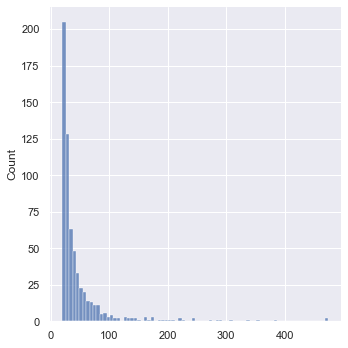

In [26]:
clusters = [c for c in clusters.communities if len(c) >= MIN_CLUSTER_SIZE]
cluster_sizes = pd.Series({k: len(v) for k,v in enumerate(clusters)})
sns.displot(cluster_sizes)

In [32]:
# Add the clusters to the graph
for cluster_id, members in enumerate(clusters):
    for m in members:
        G.add_node(m, cluster_id=cluster_id)

### Exploratory test: print samples from clusters

And now the moment we've been waiting for: how good are these things, exactly?

In [33]:
def print_cluster(df, clusters, cluster_sizes, sample_size=10, cluster_id=None):
    
    if not cluster_id:
        cluster_id = np.random.choice(cluster_sizes.index)

    print(colored(f"Cluster [{cluster_id}] has [{cluster_sizes[cluster_id]}] members.\n", "red", attrs=['bold']))

    cluster = clusters[cluster_id]
    sample = np.random.choice(cluster, min(sample_size, len(cluster)))    

    for doc_id in sample:
        print(df.tweet_text.values[doc_id].replace('\n', ''), '\n')

In [36]:
print_cluster(df, clusters, cluster_sizes)

Cluster [257] has [34] members.

Bring back rationing? Will the mindless Facebook nostalgia never end?  "🏋️When meat and all other food rationing ended in Britain in June 1954, it left the nation fitter than it had been… " 

Apocalyptic food prices, ©️Governor of The Bank of England, are the price of Tory Britain. 

@castlvillageman @DbAshby MEGA BRITISH FOOD SHORTAGES.  BIG TIME. 

£0.30/day to eat fresh food cooked from scratch if people are taught to "cook properly"? That new cookbook will sure be a best seller... 

Cheap food in Britain is about to become a thing of the past - Bloomberg 

A whole lot of pain is coming to consumers in Brexit Britain…Cheap Food in Britain Is About to Become a Thing of the Past - Bloomberg 

Cheap food in Britain is about to become a thing of the past - Bloomberg - You can have a racist, corrupt &amp; incompetent govt or you can have cheap food &amp; economic prosperity but you CAN’T have both! In #GE2019 Brits chose the latter, HELLO Food poverty! 



# A Note on Evaluation

There are really only three methods for evaluating topic models:

1. Comparison with a "ground truth".  Where labelled datasets are available (for example the benchmark "20newsgroups" dataset frequently used to evaluate topic models) it is straightforward to measure correspondence.  This approach was not available for this model.
2. Topic _coherence_ or _pereplexity_.  These are standard measures that describe the internal consistency of the found topics.  Both require that the approach taken yields a probabilistic model (and so are frequently used to evaluate modern Dirichlet-process based models) but will not be useful here.  Other methods (for example based on _information gain_) require that topics be represented as distributions of words.  Again, something not explicitly done here.
3. Human judgement.  This is probably the most important method when building a topic model for a real-world use case.  How useful do humans find the results?  

The algorithm in this workbook was developed and tested in conjunction with Public Affairs experts who were using the results to calculate the trends and flows of particular stories online.  Those individuals' judgement were the main evaluation criteria we used.

Clearly I would like to tune the various hyperparameters in this algorithm to maximise some kind of measure of topic quality.  I'll post an update to the workbook when I think of one!

# Scoring new values

Finally, a quick example to show how new-arriving data can be scored.  The beauty of using a BERT model is that the wordpiece tokenisation step enables us to easily incorporate new documents containing out-of-vocabulary words (something that has traditionally stymied probabilistic and matrix-based topic-models that rely on word-tokenisation).

In [45]:
new = "Conservative MP Lee Anderson says there isnt a massive need for food banks in the UK"

vec = model.encode(
    new, 
    convert_to_numpy=True, 
    device='cuda'
)

dists = embedding.most_similar([vec], indexer=annoy_index)
dists = [(doc_id, score) for doc_id, score in dists if score >= MIN_SIM_SCORE and score < 1.0]
C = Counter([G.nodes[id]['cluster_id'] for id, _ in dists])
cluster_id = C.most_common()[0][0]

print(colored("NEW DOCUMENT", 'red', attrs=['bold', 'underline']))
print(colored(new, attrs=['bold']), '\n')
print(colored(f"Assigned to Cluster [{cluster_id}] which has [{cluster_sizes[cluster_id]}] members.\n", 'green', attrs=['bold']))
print(colored("SIMILAR DOCUMENTS", 'red', attrs=['bold', 'underline']))

cluster = clusters[cluster_id]
sample = np.random.choice(cluster, min(10, len(cluster)))    

for doc_id in sample:
    print(df.tweet_text.values[doc_id].replace('\n', ''), '\n')

NEW DOCUMENT
Conservative MP Lee Anderson says there isnt a massive need for food banks in the UK 

Assigned to Cluster [526] which has [22] members.

SIMILAR DOCUMENTS
Clueless #tosser: "Conservative MP Lee Anderson says there isn't a massive need for food banks in the UK, it’s just that people “canno… " 

Come on, Ashfield, vote this idiot, #LeeAnderson out next time.: "Conservative MP Lee Anderson says there isn't a massive need for food banks in the UK, it’s just that people “canno… " 

Come on, Ashfield, vote this idiot, #LeeAnderson out next time.: "Conservative MP Lee Anderson says there isn't a massive need for food banks in the UK, it’s just that people “canno… " 

Anderson can fuck his own fist for the vicious stupidity of this comment.: "Conservative MP Lee Anderson says there isn't a massive need for food banks in the UK, it’s just that people “canno… " 

An MP thinking foodbanks are street food stalls: "Conservative MP Lee Anderson says there isn't a massive need for food 